# Milestone I Natural Language Processing

#### Author: Linda Nguyen


Version: 1.0

Environment: Python 3 and Jupyter notebook

## Introduction



We'll generate different types of feature representations for the collection of job advertisements.We'll only consider the description of the job advertisement. The feature representation that you need to generate includes the following:
- Bag-of-words model: we'll generate the Count vector representation for each job advertisement description, and save them into a text file. The generated Count vector representation will be based on the generated vocabulary in Task 1 as saved in vocab.txt.
- Models based on word embeddings: we'll choose the embedding language model FastText. Here, we'll build two document embeddings including  unweighted version and TFIDF weighted. 

We'll build machine learning models for classifying the category of a job advertisement text. We will choose Logistic Regression model. Next, we'll conduct two sets of experiments on the provided dataset to investigate 2 questions: 
- Q1: Which language model we built previously based on job advertisement descriptions performs the best with the built logistic regression model? To answer this, we'll compare logistic regression models with count vector, unweighted FastText and weighted TFIDF FastText. 
- Q2: Does more information provide higher accuracy? To answer this, we'll experiment on 3 datasets: Title, Description, Title+Description. We'll choose logistic regression with count vector representation to do comparision. 

We'll evaluate the performance of each model in Task 3 by conducting 5-fold cross validation. 

## Importing libraries 

In [1]:
# import libraries
import re
import gensim.downloader as api
import pandas as pd
from gensim.models.fasttext import FastText
import os
import numpy as np
from itertools import chain
import gensim.models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
from gensim.utils import tokenize

## Step 2. Generating Feature Representations for Job Advertisement Descriptions

After text pre-processing has been completed, each individual document needs to be transformed into 
some kind of numeric representation that can be input into most NLP and text mining algorithms. <br>

In this task, we'll generate different types of feature representations for the collection ofjob advertisements. However, we'll only consider the description of the job advertisement. The feature representation that you need to generate includes the following: <br>
- Bag-of-words model : we'll generate the Count vector representation for each job advertisement description, and save them into `count_vectors.txt`.Here, the generated Count vector representation will be based on the generated vocabulary in Task 1 which as saved in `vocab.txt`. 
- Models based on word embeddings: we'll generate feature representation of job advertisement description based on FastText embedding language model. We'll build 2 feature representation of documents: TF-IDF weighted and unweighted version. 

## 1.  Bag-of-words model

In this sub-task, the generated Count vector representation which based on the generated vocabulary in Task 1. Thus, we need to import `vocab.txt`. 

In [2]:
with open('vocab.txt', 'r') as f: # read vocab
    vocab = f.read().splitlines() # read and split lines of vocab
    vocab = sorted([re.sub(r':\d+$', '', w) for w in vocab]) # extract words of each line and replace index number by empty string

In [3]:
len(vocab) # check number of vacab

9404

Here, we have 9404 vocabularies.

In below block of code, we'll extract ID, Category, Title and Webindex and Description from `job_ads.txt` that processed on task 1. To do this, we need to create new list for each feature, we extract information of each feature from the imported text file using Regex pattern, then save it into the responding lists. 

In [4]:
# create new lists
jobIds = []
categories = []
titles = []
webIndexes = []
jobDes = []
with open('./job_ads.txt', 'r') as f: # open a text file in read mode
    lines = f.read().splitlines() # read and split file in lines
    for line in lines: # loop lines
        
        if len(line) != 0 and line.startswith('ID:'): # extract line starts with 'ID:'
            idx = re.sub(r'^ID:\s*', '', line) # extract text after 'ID: '   
            jobIds.append(idx) # add the extracted line in list jobIds           
             
        if len(line) != 0 and line.startswith('Category'): #  extract line starts with 'Category'    
            category = re.sub(r'^Category:\s*', '', line) # extract text after 'Category: '
            categories.append(category) # add the extracted line list categories
                            
        if len(line) != 0 and line.startswith("Title:"):  # extract line starts with 'Title'
            line = re.sub(r'^Title:\s*', '', line).lower() # extract text after 'Titles: ', and convert them to lower case  
            titles.append(line) # add the extrated line to list titles
            
        if len(line) != 0 and line.startswith('Webindex'): #  extract line starts with 'Webindex: '
            webindex = re.sub(r'^Webindex:\s*', '', line)# extract text after 'Webindex: '           
            webIndexes.append(int(webindex))  # add them to list webIndexes
   
        if len(line) != 0 and line.startswith('Description'):    # extract line starts with 'Description'
            description = re.sub(r'^Description:\s*', '', line)  # extract text after 'Description: '
            jobDes.append(description)   # add extracted line in list jobDes     

Double check if all these list have the same number of 776 job advertisements.

In [5]:
len(jobDes) == len(jobIds) == len(categories) == len(webIndexes) == len(titles) == 776

True

They all have 776 job advertisements. 

### 1.1. Count vector representation

In this subtasks, we will generate the count vector features of job texts. Here we'll use scikit-learn to carry out this task. <br>
We firstly need to initialise the CountVectorizer. The CountVectorizer will convert a collection of job text documents to a matrix of token counts. Then we reconstruct the count vector representations. 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
# initialised the CountVectorizer
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab)

# generate the count vector representation for all job advertisment
count_features = cVectorizer.fit_transform(jobDes) 

# check size
print(count_features.shape)

(776, 9404)


In the below block of code, we define a function to write vector files. As requirement, we need to generate a `count_vectors.txt` which store webindex and word_index:value. 

In [7]:
def write_file(data_features,filename): # define a function 
    num = data_features.shape[0] # number of file
    out_file = open(filename, 'w') # creates txt file in write mode
     
    for index in range(0, num): # loop through each article by index
        out_file.write('#' + str(webIndexes[index]))  # start string with # 
        
        for f_ind in data_features[index].nonzero()[1]:  # for each index that is not zero from data_features
            value = data_features[index][0,f_ind]  # retrieve value entry from data_features    
            
            out_file.write(',') # add comma after index number          
            out_file.write("{}:{}".format(f_ind,value)) # write value in file with format word_index:value
      
        out_file.write('\n') # start new line for new job ad   
    out_file.close()  # close file   

#### Save output of Count vector representation

In [8]:
write_file(count_features, 'count_vectors.txt')

### 1.2. TFIDF vector representation (for next task FastText TFIDF)

Here, we'll generate the TF-IDF Vector to represent each job document.

Similar to the use of CountVector, first initialise a TfidfVectorizer object by only specifying the value of "analyzer" and the vocabulary, and then convert the jobDes into a list of strings, each of which corresponds to a job advertisement.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
# initialised the TfidfVectorizer
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab)

# reconstructing the tfidf vector representations
tfidf_vector = tVectorizer.fit_transform(jobDes) 

# check size
tfidf_vector.shape

(776, 9404)

Extracting the weight for words in each job description from tfidf vector. We will create an empty list to store the dictionary of word:weight for each job description. Then we'll extract the 

In [10]:
def word_weight(tfidf_vector, vocab):
    
    tfidf_features = []  # create an empty list
    sorted(vocab) # sort vocab
    
    for i in range(tfidf_vector.shape[0]): # for each index in tfidf_vector 
        jobAd = {} # create a dict to store job des
        
        for word_index in tfidf_vector[i].nonzero()[1]:# get index >0
            weight = tfidf_vector[i][0, word_index] # get weight of word by index
            jobAd[vocab[word_index]] = weight # allocate word in vocab by index then get word to the coresponding weig
                                    
        tfidf_features.append(jobAd)  # add dict to tfidf_features list
    
    return tfidf_features

In [11]:
# get word:weight
tfidf_features = word_weight(tfidf_vector, vocab)

### 1.3. Validation 

In this section, we'll validate the correctness of outputs for count vector, also we will compare the output bewween count vector and tfidf vector representation. We'll test index=2 which is the 3rd job advertisement. We'll check if they are matched when we use 2 different vector represenation. <br>
Firstly, we need to define a validator function: 

In [12]:
def validator(data_features, vocab, index, article_ids,article_txts,tokenised_articles):
    
    print("ID:", article_ids[index]) # print out the job ID
    print("--------------------------------------------")
    print("description text:",article_txts[index]) # print out the txt of the job description
    print("--------------------------------------------\n")
    print("description tokens:",tokenised_articles[index]) # print tokens of job description
    print("--------------------------------------------\n")
    print("Vector representation:\n") 
   
    # printing the vector representation as format 'word:value', the value is an integer for count vector
    for word, value in zip(vocab, data_features.toarray()[index]): 
        if value > 0: # give value greater than 0
            print(word + ":" + str(value), end =' ') # format output as requried

In [13]:
# check the third job advertisement for count vector
validator(count_features, vocab, 2, jobIds,jobDes,[i.split(' ') for i in jobDes])

ID: 00547
--------------------------------------------
description text: exciting arisen establish provider elderly care deputy home home day day running home passion care sector proven description assist registered home responsibility home absence registered requirements ensure standards care delivered meet individual residents ensure healthcare residents met liaising gp district nurses supervision registered lead manage develop staff assist registered home responsibility running home absence registered qualifications nvq level care residential home older people supervisory flexible shift pattern totaljobs
--------------------------------------------

description tokens: ['exciting', 'arisen', 'establish', 'provider', 'elderly', 'care', 'deputy', 'home', 'home', 'day', 'day', 'running', 'home', 'passion', 'care', 'sector', 'proven', 'description', 'assist', 'registered', 'home', 'responsibility', 'home', 'absence', 'registered', 'requirements', 'ensure', 'standards', 'care', 'delivere

As we see, for bag of words count vector, the vector represenation shows the word and number of occurrency of that word in the doccument. 

In [14]:
# check the third job advertisement for tfidf vector
validator(tfidf_vector, vocab, 2, jobIds,jobDes,[i.split(' ') for i in jobDes])

ID: 00547
--------------------------------------------
description text: exciting arisen establish provider elderly care deputy home home day day running home passion care sector proven description assist registered home responsibility home absence registered requirements ensure standards care delivered meet individual residents ensure healthcare residents met liaising gp district nurses supervision registered lead manage develop staff assist registered home responsibility running home absence registered qualifications nvq level care residential home older people supervisory flexible shift pattern totaljobs
--------------------------------------------

description tokens: ['exciting', 'arisen', 'establish', 'provider', 'elderly', 'care', 'deputy', 'home', 'home', 'day', 'day', 'running', 'home', 'passion', 'care', 'sector', 'proven', 'description', 'assist', 'registered', 'home', 'responsibility', 'home', 'absence', 'registered', 'requirements', 'ensure', 'standards', 'care', 'delivere

Here, for TFIDF vector, the vector representation shows word and weight of that word. 

The above output can tell us the output of 2 validators are matched. 

## 2.  Models based on word embeddings

In this part, we'll do the following tasks:

- build a dataframe to store description info
- create corpus file `descriptions.txt` for FastText models
- define a funtion `plotTSNE` to visualise space features of each models
- generate FastText unweighted (included build unweighted vector represenataion) 
- generate FastText ITFIDF (included build TFIDF vector represenataion)

Earlier, we processed the text file `job_ads.txt`, we extracted each feature and save each of them in a list. Now, we 'll put all in a dataframe. Each column will store a feature of a job ads including jobIds, categories, webIndexes, titles,jobDescription. Later we will need to experiments model performance on different datasets so this will also be helpful for next tasks. 

In [15]:
# make an empty data frame
df = pd.DataFrame()

# adding information of job ads into data frame
df['ID'] = jobIds
df['Category'] = categories
df['webIndexes'] = webIndexes
df['Titles'] = titles
df['descriptionText'] = jobDes
df['tk_description'] = [a.split(' ') for a in jobDes] # get the tokens for each jobDes
df.sample(3)

,ID,Category,webIndexes,Titles,descriptionText,tk_description
490,00392,Accounting_Finance,69030000,risk analyst insurance,risk division closely head risk risk execution...,"[risk, division, closely, head, risk, risk, ex..."
184,00081,Engineering,70218857,technician,mott macdonald global engineering consultancy ...,"[mott, macdonald, global, engineering, consult..."
736,00545,Healthcare_Nursing,71090289,rgn staff nurse cardiff,rgn newport hour small group nursing homes sou...,"[rgn, newport, hour, small, group, nursing, ho..."


Here, we are require to experiment model performance on job Description only, we need to create a new list to store the tokenized text of Description as above. Then add it to the daatframe. 

### 2.1 FastText

We chose FastText as the embedding language model. <br>
We'll create the `descriptions.txt` file that save jobDes text in row seperated by line. This text file will be used to generate the corpus for jobDes in training Fastext model later. 

In [16]:
# Create a function to save jobDes text in row seperated by line
def file (filename, data):
    # creates a txt file named filename, open in write mode
    out_file = open(filename, 'w')
    # loop throught each jobDes text 
    for i in data:  
        # write them by string + new line
        out_file.write(i + '\n')  

In [17]:
filename = './descriptions.txt'
file (filename, jobDes)

In the following block of code, we'll:<br>

- set the path to the corpus file <br>
- use the description as the training corpus <br>
- initialise the FastText model, use 200 dimention vectors <br>
- build the vocabulary from the copurs <br>
- train the fasttext model based on the corpus. <br>

In [18]:
# set the corpus file names/path
corpus_file = './descriptions.txt'

# initialise the Fast Text model 
descriptions_FastText = FastText(vector_size=200) 

# build the vocabulary 
descriptions_FastText.build_vocab(corpus_file=corpus_file)

# train the model
descriptions_FastText.train(
    corpus_file=corpus_file, epochs=descriptions_FastText.epochs,
    total_examples=descriptions_FastText.corpus_count, total_words=descriptions_FastText.corpus_total_words)

# see the size of descriptions_FastText 
print("descriptions_FastText: ", descriptions_FastText)

# retrieve the KeyedVectors from the model
descriptions_FastText_wv = descriptions_FastText.wv
print("KeyedVectors:", descriptions_FastText_wv)

descriptions_FastText:  FastText(vocab=2741, vector_size=200, alpha=0.025)
KeyedVectors: <gensim.models.fasttext.FastTextKeyedVectors object at 0x00000258D46F6430>


### save jobFT.model for web app Flask

In [19]:
descriptions_FastText.save ('jobFT.model')

#### Understand our task by TSNE

We'll construct a function to do the embeddings. The following function plotTSNE takes the following arugments: 
- labels, category of each job ad
- features, a numpy array of document embeddings, each for a job ad
- projects the feature/document embedding vectors in a 2 dimension space and plot them out. 

It performs as below: 
- get the set of classes, called categories (4 categories)
- sample 30% of the data/document embeddings randomly, and record the indices selected
- project the selected document embeddings in 2 dimensional space using tSNE, each document embedding now corresponds to a 2 dimensional vector in projected_features
- plot them out as scatter plot and highlight different categories in different color

In [20]:
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(features.shape[0] * 0.15)
    np.random.seed(0)
    indices = np.random.choice(range(features.shape[0]), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange' ]
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each job, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

### 2.1.1.  FastText unweighted 

Before build FastText unweighted we need to buid `unweighted vector representation` function. 

Here, we will generate a function of unweighted vector document. 
Ok, once we have the word:weight dictionary of each document, now we can construct the tf-idf weighted document embeddings.

The following function takes: wv, an word:embedding dictionary or KeyedVectors and tk_txts, a list of tokenized texts, each of an article. It then does the following to generate the list of embedding vector representations.
For each for an article, it creates an empty dataframe docs_vectors to store the document embeddings of articles. It loop through every tokenized text:
* creates an empty dataframe temp to store all the word embeddings of the article
* for each word that exists in the word embeddings dictionary/keyedvectors, row bind the word embedding to temp
* take the sum of each column to create the document vector
* append the created document vector to the list of document vectors.

In [21]:
def unweighted_docVecs(wv,tk_txts): # generate vector representation for documents
    docs_vectors = [] # creating empty final list

    for i in range(0,len(tk_txts)):                
        tokens = tk_txts[i]        
        temp = []  # creating a temporary list(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
   
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
           
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(google provides weights associate with words(300)) then proceed
                temp.append(word_vec) # if word is present then append it to temporary list
            except:
                pass
        doc_vector = sum(temp) # take the sum of each array
        docs_vectors.append(doc_vector) # append each document value to the final list
                          
    return pd.DataFrame(docs_vectors) # return a dataframe of docs_vectors

Now, it's time to build FastText unweighted represenatation for description. 

In [22]:
# generate document embeddings
unweighted_fastText =  unweighted_docVecs (descriptions_FastText_wv,df['tk_description'])  
# check whether there is any null values in the document vectors dataframe
unweighted_fastText.isna().any().sum()   

0

In [23]:
print(unweighted_fastText.shape)
unweighted_fastText.head()

(776, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-16.345730,5.624237,6.359018,-4.649707,23.539152,-2.348161,-5.437834,-9.415196,5.013567,-5.427425,...,2.657426,-1.678807,13.744378,-17.484774,-3.318793,-1.547721,-18.868382,-6.283132,-2.566699,16.091675
1,-15.477402,4.862271,6.000383,-3.457246,23.396303,-2.723041,-4.731733,-9.166815,5.399197,-4.744331,...,2.287646,-1.980647,13.508481,-16.933237,-3.072452,-1.030905,-19.030243,-6.970247,-2.729175,15.646471
2,-24.161621,8.535116,9.387934,-7.580869,30.630959,-2.938964,-9.134142,-12.646901,5.084204,-10.103042,...,3.002371,-0.939406,17.256525,-23.725836,-5.986938,-3.397403,-22.240606,-6.571515,-2.969987,21.809746
3,-10.179917,3.344000,4.161112,-2.657998,14.997528,-1.711448,-3.390834,-5.905459,3.294043,-3.337158,...,1.580999,-1.253617,8.713599,-11.050749,-2.154203,-0.985582,-12.082985,-4.170295,-1.652139,10.094860
4,-28.192083,11.578289,10.521323,-11.945136,35.295902,-1.099445,-10.546811,-15.371443,5.574364,-10.380315,...,5.543378,-0.798057,21.326876,-28.307695,-5.299165,-4.152341,-27.280128,-6.720054,-3.054293,25.301254


See how the classes are seperated in feature space:

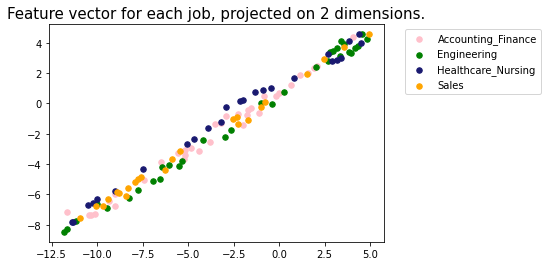

In [24]:
# explore feature space
features = unweighted_fastText.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(df['Category'],features) # plot the tSNE based on Category

In this plot, the 4 classes not separated at all, they are mixed up to each other. It looks very messy. 

### 2.1.2.  FastText weighted TFIDF

Before building FastText weighted TFIDF model, we need to generate TFIDF doccumnent vector represenatation for Description. 

Here, we'll build the TFIDF document embeddings. We do word embedding vectors, the weights here refers to the TFIDF weight of the word. We construct the TFIDF weighted document embeddings. 

The following function takes: wv, an word:embedding dictionary or KeyedVectors and tk_txts, a list of tokenized texts, each of an article. It then does the following to generate the list of embedding vector representations.
For each for an article, it creates an empty dataframe docs_vectors to store the document embeddings of articles. It loop through every tokenized text:
* creates an empty dataframe temp to store all the word embeddings of the article
* for each word that exists in the word embeddings dictionary/keyedvectors, row bind the word embedding to temp
* take the sum of each column to create the document vector
* append the created document vector to the list of document vectors.

In [25]:
def TFIDF_docVecs (wv,tk_txts,tfidf = []): # generate vector representation for documents
    docs_vectors = [] # creating empty final list

    for i in range(0,len(tk_txts)):
        tokens = list(set(tk_txts[i])) # get the list of distinct words of the document
        

        temp = []  # creating a temporary list(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings then proceed
                
                if tfidf != []:
                    word_weight = float(tfidf[i][word])
                else:
                    word_weight = 1
                        
                temp.append(word_vec*word_weight)# if word is present then append it to temporary list
            except:
                pass
        
        doc = sum(temp) # take the sum of array
        docs_vectors.append(doc) # append each document value to the final list
        
    return pd.DataFrame(docs_vectors)

Now, it's time to build FastText TFIDF represenatation for description. 

In [26]:
# generating TFIDF vectors
weighted_TFIDF_FastText = TFIDF_docVecs (descriptions_FastText_wv,df['tk_description'],tfidf_features)

In [27]:
print(weighted_TFIDF_FastText.shape)
weighted_TFIDF_FastText.head()

(776, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.792629,0.618025,0.690746,-0.511626,2.576041,-0.253000,-0.593391,-1.032871,0.546003,-0.592533,...,0.296046,-0.180231,1.507185,-1.914354,-0.360597,-0.165545,-2.067281,-0.688742,-0.279749,1.761564
1,-1.258139,0.399993,0.492812,-0.291322,1.894060,-0.217483,-0.390515,-0.742579,0.434066,-0.390968,...,0.187308,-0.160282,1.093845,-1.375801,-0.251373,-0.091360,-1.536922,-0.556678,-0.219604,1.268657
2,-1.905179,0.670705,0.734884,-0.591431,2.435555,-0.233355,-0.711453,-1.004337,0.411347,-0.784117,...,0.243304,-0.079622,1.377386,-1.878794,-0.464913,-0.257417,-1.785056,-0.534391,-0.237675,1.729242
3,-1.330747,0.435406,0.541501,-0.343644,1.964607,-0.224973,-0.439925,-0.774222,0.431778,-0.433436,...,0.209094,-0.163591,1.143526,-1.446814,-0.280691,-0.124567,-1.586444,-0.550354,-0.216217,1.320161
4,-2.096895,0.837828,0.801370,-0.840854,2.693050,-0.121155,-0.778214,-1.149918,0.451830,-0.770176,...,0.390604,-0.090333,1.607722,-2.129403,-0.404568,-0.301400,-2.088403,-0.543521,-0.244992,1.913085


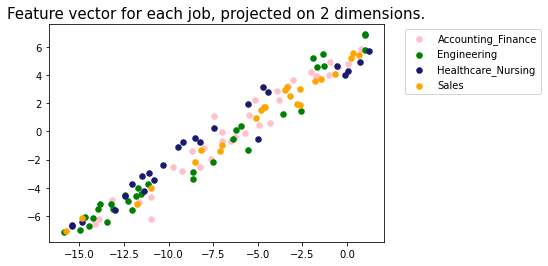

In [28]:
features = weighted_TFIDF_FastText.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(df['Category'],features) # plot the tSNE base on Category

Again, this not better than the previous model, the classes are not separted well on this model. 

## Step 3. Job Advertisement Classification

In this task, we'll build machine learning models for classifying the category of a job advertisement text. We'll build the logistic regression model from sklearn. We'll conduct 2 sets of experiments on our dataset to investigate 2 questions: 





### Question 1- Language model comparisons

In this task, we will investigate which language model we built previously based on job advertisement descriptions, performs the best with the logistic regression (LR) machine learning model.  To answer this question, we'll build LR machine learning models based on the feature representations of the documents you generated in task 2, and to perform evaluation on the various model performance. <br>

We'll compare 3 models: 

* Logistic regression model with count vector representation
* Logistic regression model with unweighted FastText
* Logistic regression model with weighted TFIDF FastText

#### 1. Build logistic regression model

In [29]:
# build a function to train the model and get the accuracy score
def logistic_regression (vector_feature, labels):
    
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(vector_feature, labels, test_size=0.33, random_state=0)
    # initial a logistic regression model
    model = LogisticRegression(max_iter=1000, random_state=0) 
    # fit model
    model.fit(X_train, y_train)
    # calculated the accuracy score on the test data
    score =model.score(X_test, y_test)
    return score

In [30]:
# creating training and test split

seed=0
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(weighted_TFIDF_FastText, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

import pickle
pkl_filename = "jobFT_LR.pkl"
with open(pkl_filename, 'wb') as file:
     pickle.dump(model, file)

#### 2. Test Logistic Regression model with three chosen feature represenations

Let's explore the preformance of this logistic regression model on these 3 different feature representations we have chosen.
We will replace `vector_feature` with `count_features`, `unweighted_fastText`, `weighted_TFIDF_FastText` coresponding to each feature represenataion. 

In [31]:
# LR model on count vector
logistic_regression (count_features, df['Category'])

0.8793774319066148

In [32]:
# LR model on unweighted FastText
logistic_regression (unweighted_fastText, df['Category'])

0.8093385214007782

In [33]:
# LR model on weighted TFIDF FastText
logistic_regression (weighted_TFIDF_FastText, df['Category'])

0.7120622568093385

We can see that our LR model have performed quite good on these three different feature represenatations beacuse they can predict above 70% accuracy. However, we still need to perform evaluation on these model performance by using 5-fold cross validation. 

#### 3.    5-Fold Cross Validation

In this task, we'll evaluate our model performance by 5-fold cross validation. We'll train the model 5 times then store the accuracy score of each fold in a dataframe. Next, we will determine the accuracy score by compute its average, then we will compare the average score of the feature representation. 

In [34]:
# initialise a 5 fold validation
num_folds = 5 
kf = KFold(n_splits= num_folds, random_state=0, shuffle = True)  # initialise a 10 fold validation
print(kf)

KFold(n_splits=5, random_state=0, shuffle=True)


In [35]:
# using kfold cross validation to train the model 5 times
def evaluate(X_train,X_test,y_train, y_test):
    
    model = LogisticRegression(max_iter = 1000,random_state=0) # initial a logistic regression model
    model.fit(X_train, y_train) # fit model, use train datsets to train the model
    return model.score(X_test, y_test)  # calculated the accuracy score on the test data

In [36]:
# save accuracy scores in a dataframe
description_df = pd.DataFrame(columns = ['count_vectors','FastText_unweighted','FastText_TFIDF' ],index=range(5)) 

In this block of codes, we initialise the index of the datframe of each fold. Then for each fold, we capture the train index and text index, get their labels and train the model by unweighted and weighted vector features. We'll train model by 5 vector features that we have worked in the previous tasks.   

In [37]:
# intialize the index of dataframe by each fold
fold = 0
# capture the train_index, test_index for each time data got split 
for train_index, test_index in kf.split(list(range(len(df)))):

    # get label of train dataset
    y_train = [categories[i] for i in train_index]
    # get label of test dataset
    y_test = [categories[i] for i in test_index]
    
    # train model by bag_of_words_TFIDF
    description_df.loc[fold,'count_vectors'] = evaluate(count_features[train_index,],count_features[test_index,],y_train,y_test)

    # train model by unweighted FastText     
    description_df.loc[fold,'FastText_unweighted'] = evaluate(unweighted_fastText.loc[train_index,],unweighted_fastText.loc[test_index,],y_train,y_test)                                             
    
    # train model by unweighted FastText
    description_df.loc[fold,'FastText_TFIDF'] = evaluate(weighted_TFIDF_FastText.loc[train_index,],weighted_TFIDF_FastText.loc[test_index,],y_train,y_test)
   
    fold +=1 # move to the next row in the data frame

Printing the result of each fold for each vector representation:

In [38]:
description_df

,count_vectors,FastText_unweighted,FastText_TFIDF
0,0.852564,0.788462,0.737179
1,0.883871,0.83871,0.722581
2,0.890323,0.819355,0.787097
3,0.877419,0.780645,0.696774
4,0.916129,0.774194,0.735484


In [39]:
# compute the average score for each model
average_score_description = description_df.mean()
average_score_description 

count_vectors          0.884061
FastText_unweighted    0.800273
FastText_TFIDF         0.735823
dtype: float64

We can see count vectors represenation give the highest accuracy which is about 88% while FastText unweighted and FastText TFIDF embedding language models give lower accuracy. 

=> Answer Question 1: Among the language models we built previously on task 2 based on job advertisement descriptions, the built logistic regression machine learning model performs the best on count vectors representation.

### Question 2- Does more information provide higher accuracy?

In Task 2, we have built a number of feature representations of documents based on job advertisement descriptions. However, we have not explored other features of a job advertisement, e.g., the title of the job position. Will adding extra information help to boost up the accuracy of the model? To answer this question, we'll conduct experiments to build and compare the performance of classification models that considering:
- only title of the job advertisement
- only description of the job advertisement which we’ve already done. 
- both title and description of the job advertisement.

In this task, we'll build logistic regresstion model with count vector representation based on info of Title and Title+Description. We then investigate whether adding more infomation helps to boost up the model's performance.

### 1. Experiment on Titles

In this part, we'll do the following tasks:

- data pre-processing Titles (text tokenisation, remove single character words, remove stopwords)
- generate vector representation beased on the cleaned Titles 
- test the performance of logistic regression model that have been built on Task 2
- validate model performance by 5-fold cross validation
- Compute the average score of these 5 folds

First, let's have a quick look what do we have in titles list that we processed earlier. 

In [40]:
titles

['finance / accounts asst bromley to ****k',
 'fund accountant  hedge fund',
 'deputy home manager',
 'brokers wanted imediate start',
 'rgn nurses (hospitals)  penarth',
 'production coordinator',
 'scrub nurse',
 'sales & purchase ledger clerk  maternity cover',
 'recruitment sales executive',
 'business development executive  field sales  dartford',
 'investments & treasury controller',
 'european payroll',
 'engineering assessor / instructor  south yorkshire',
 'international account manager',
 'senior production technologist (malaysia)',
 'insurance sales executive  horsham',
 'vehicle purchaser / car sales',
 'marine engines specialist – product support',
 'sales manager/medical sales executive',
 'optical assistant  oxfordshire',
 'perm unit mgr rgn kid minster flexi ****k due',
 "perm rgn's in bangor codown  f/t flexi  ****ph exopp  bangor",
 'ecommerce country manager (netherlands)',
 'business development manager  leading financial lending plc',
 'dynamics ax finance consulta

### Data pre-processing titles

We need to pre-process titles before building models. Here, the each job title is quite short so only neeed to preprocess few neccesary steps including: 
- tokenize the text
- remove single character words 
- remove stopwords. 

In [41]:
# tokenize titles and put then in a list 
tk_titles = [list(tokenize(i)) for i in titles]

We create a statistics function to check stats at each stage: 

In [42]:
# takes a tokenize title list and display the number of vocab, words, Lexical diversity, max/min/average review length
def stats_print(tk_title):
    words = list(chain.from_iterable(tk_title)) # we put all the tokens in the corpus in a single list 
    vocab = set(words) # compute the vocabulary by converting the list of words/tokens to a set
    lexical_diversity = len(vocab)/len(words) # compute lexical_diversity
    print("Vocabulary size: ",len(vocab))
    print("Total number of tokens: ", len(words))
    print("Lexical diversity: ", lexical_diversity)
    print("Total number of title:", len(tk_title))
    lens = [len(j) for j in tk_title]  # compute number of tokens 
    print("Average title length:", np.mean(lens))
    print("Maximun title length:", np.max(lens))
    print("Minimun title length:", np.min(lens))
    print("Standard deviation of title length:", np.std(lens))

In [43]:
# remove single character words
tk_titles = [[ word for word in t if len(word) >1] for t in tk_titles]

In [44]:
# check stats
stats_print(tk_titles)

Vocabulary size:  984
Total number of tokens:  3077
Lexical diversity:  0.31979200519987
Total number of title: 776
Average title length: 3.9652061855670104
Maximun title length: 12
Minimun title length: 1
Standard deviation of title length: 1.7350467799519218


In [45]:
# load the provided stopword file
stopwords_en = []
with open('./stopwords_en.txt') as f:
    stopwords_en = f.read().splitlines()

In [46]:
# filter out the tokens that belong in stopword_en
tk_titles = [ [w for w in t if w not in stopwords_en]  for t in tk_titles]

In [47]:
# check stats
stats_print(tk_titles)

Vocabulary size:  953
Total number of tokens:  2963
Lexical diversity:  0.32163347958150523
Total number of title: 776
Average title length: 3.818298969072165
Maximun title length: 10
Minimun title length: 1
Standard deviation of title length: 1.5653217426587334


In [48]:
# add tk_titles on data frame
df['tk_titles'] = tk_titles

In [49]:
# join tokens 
df['titlesText'] = df['tk_titles'].apply(lambda x: ' '.join(x))

In [50]:
# display 3 random rows
df.sample(3)

,ID,Category,webIndexes,Titles,descriptionText,tk_description,tk_titles,titlesText
191,00310,Accounting_Finance,71293696,commercial team leader,highly regarded professional insurance brokera...,"[highly, regarded, professional, insurance, br...","[commercial, team, leader]",commercial team leader
54,00287,Accounting_Finance,62016897,claims negotiator,major industry record consistent growth recrui...,"[major, industry, record, consistent, growth, ...","[claims, negotiator]",claims negotiator
754,00406,Accounting_Finance,68677615,associate consultant london,associate consultant london continuous growth ...,"[associate, consultant, london, continuous, gr...","[associate, consultant, london]",associate consultant london


In [51]:
# get list of words of titles
words_title =  list(chain.from_iterable(df['tk_titles'].tolist())) 

In [52]:
# get the unique vocab the list titles
vocab_title = sorted(list(set(words_title)))

In [53]:
# show vocab_title
vocab_title

['abbey',
 'aberdeen',
 'abi',
 'accepted',
 'accounant',
 'account',
 'accountancy',
 'accountant',
 'accounting',
 'accounts',
 'actions',
 'activities',
 'activity',
 'addictions',
 'adjusting',
 'administartor',
 'administration',
 'administrator',
 'adolescent',
 'adult',
 'adults',
 'advanced',
 'advertising',
 'advice',
 'adviser',
 'advisers',
 'advisor',
 'advisors',
 'affinities',
 'agency',
 'agent',
 'air',
 'allied',
 'allowance',
 'americas',
 'amigo',
 'amp',
 'analogue',
 'analysis',
 'analyst',
 'analystbelfast',
 'angiography',
 'application',
 'applications',
 'apply',
 'apprentice',
 'architect',
 'area',
 'arm',
 'art',
 'asbestos',
 'asda',
 'ashford',
 'asp',
 'assembler',
 'assembly',
 'assessor',
 'asset',
 'assistant',
 'assistants',
 'assisted',
 'assitant',
 'associate',
 'asst',
 'assurance',
 'attendent',
 'audio',
 'audit',
 'auditor',
 'auto',
 'autodesk',
 'automation',
 'automotive',
 'auxiliary',
 'avp',
 'ax',
 'ayrshire',
 'band',
 'bangor',
 'bank'

In [54]:
# check size of vocab
len(vocab_title)

953

### Count vector representation
Again, we will generate the count vector features of titles. We'll use scikit-learn to carry out this task. We firstly need to initialise the CountVectorizer. The CountVectorizer will convert a collection of titles text documents to a matrix of token counts. Then we reconstruct the count vector representations. 

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
# initialised the CountVectorizer
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab_title)

# generate the count vector representation for all job ads
count_features_titles = cVectorizer.fit_transform(titles) 

# check size
print(count_features.shape)

(776, 9404)


In [56]:
# save accuracy scores in a dataframe
df_titles = pd.DataFrame(columns = ['count_vectors' ],index=range(5)) 

### Test Logistic Regression model with count vector epresenations
Now, let's see how these feature represenations perform on our logistic regression model beased on info of Titles only. 
We will replace `vector_feature` with `count_features_titles`. 

In [57]:
# LR model on count vectors
logistic_regression (count_features_titles, df['Category'])

0.8210116731517509

We can see this model can predict about 80% accuracy that is good but we still need to cross validate its performance.

Now, let's do 5-fold cross validation to validate the correctnesss of this model' performance.

### 5-fold cross validation
In this task, we'll validate the correctness of the model by 5-fold cross validation. It means we will train the model 5 times, each time it will give us different score of accuracy. Ww then evaluate the model accuracy by computing the average score. 

In [58]:
# save accuracy scores in a dataframe
df_titles = pd.DataFrame(columns = ['count_vectors'],index=range(5)) 

In this task, we validate our model correctness by k-fold cross validation. We'll train the model 5 times then store the accuracy score of each fold in a dataframe. Next, we will determine the accuracy score by compute its average, then we will compare the average score of the feature representation. 

In [59]:
# intialize the index is 0
fold = 0
# capture the train_index, test_index for each time data got split 
for train_index, test_index in kf.split(list(range(len(df)))):

    # get label of train dataset
    y_train = [categories[i] for i in train_index]
    # get label of test dataset
    y_test = [categories[i] for i in test_index]

    #  train model by count vector feature representation 
    df_titles.loc[fold,'count_vectors'] = evaluate(count_features_titles [train_index,],count_features_titles [test_index,],y_train,y_test)
    
    fold +=1 # move next fold, one line for each fold

In [60]:
# show dataframe 
df_titles

,count_vectors
0,0.807692
1,0.864516
2,0.812903
3,0.825806
4,0.812903


In [61]:
# compute average score of accuracy of each model
average_score_titles = df_titles.mean()
average_score_titles

count_vectors    0.824764
dtype: float64

### 2. Experiment on Titles + Descriptions

In this experiment, we will do the following task:

- merge Titles and Descriptions 
- generate count vector representation based on the merged info
- test the performance of logistic regression model 
- validate model performance by 5-fold cross validation
- compute the average score of these 5 folds


### Merge titles and descriptions. 

In [62]:
# join the tokens of titles and descriptions
df['Title+Description'] = df['titlesText'] + ' ' + df['descriptionText']
title_and_description= df['Title+Description']
title_and_description

0      finance accounts asst bromley accountant partq...
1      fund accountant hedge fund hedge funds london ...
2      deputy home manager exciting arisen establish ...
3      brokers wanted imediate start expanding recrui...
4      rgn nurses hospitals penarth rgn nurses hospit...
                             ...                        
771    apply today start tomorrow sales today start t...
772    assembly production technicians milton keynes ...
773    medical sales executive associate orthopaedics...
774    mobile optometrist oxford mobile optometrist p...
775    field sales executive title field executive of...
Name: Title+Description, Length: 776, dtype: object

In [63]:
# create new column tk_title_description for df by join all token of each line 
df['tk_title_description'] = df['Title+Description'].apply(lambda a: a.split(' '))

In [64]:
df.sample(3)

,ID,Category,webIndexes,Titles,descriptionText,tk_description,tk_titles,titlesText,Title+Description,tk_title_description
179,00077,Engineering,72406398,graduate sales engineer (machine and consumables),graduate engineer machine consumables ote full...,"[graduate, engineer, machine, consumables, ote...","[graduate, sales, engineer, machine, consumables]",graduate sales engineer machine consumables,graduate sales engineer machine consumables gr...,"[graduate, sales, engineer, machine, consumabl..."
697,00363,Accounting_Finance,71748554,personal injury solicitor / auditor,location bradford leeds personal injury paying...,"[location, bradford, leeds, personal, injury, ...","[personal, injury, solicitor, auditor]",personal injury solicitor auditor,personal injury solicitor auditor location bra...,"[personal, injury, solicitor, auditor, locatio..."
558,00730,Sales,69556224,industrial sales engineer x ****,engineering qualification title industrial eng...,"[engineering, qualification, title, industrial...","[industrial, sales, engineer]",industrial sales engineer,industrial sales engineer engineering qualific...,"[industrial, sales, engineer, engineering, qua..."


In [65]:
# get list of words of title+description
words_title_description =  list(chain.from_iterable(df['tk_title_description'].tolist())) 

In [66]:
# get vovab of title+description
vocab_title_description = sorted(list(set(words_title_description)))

In [67]:
# have a look the vacab list of title_description
vocab_title_description

['aap',
 'aaron',
 'aat',
 'abb',
 'abbey',
 'abenefit',
 'aberdeen',
 'abi',
 'abilities',
 'abreast',
 'abroad',
 'absence',
 'absolute',
 'ac',
 'aca',
 'academic',
 'academy',
 'acca',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'access',
 'accessible',
 'accident',
 'accommodates',
 'accommodation',
 'accomplished',
 'accordance',
 'accounant',
 'account',
 'accountabilities',
 'accountability',
 'accountable',
 'accountancy',
 'accountant',
 'accountants',
 'accounting',
 'accounts',
 'accreditation',
 'accredited',
 'accruals',
 'accuracy',
 'accurate',
 'accurately',
 'achievable',
 'achieve',
 'achieved',
 'achievement',
 'achievements',
 'achiever',
 'achieving',
 'acii',
 'acquired',
 'acquisition',
 'acquisitions',
 'act',
 'acting',
 'action',
 'actions',
 'actionscript',
 'active',
 'actively',
 'activites',
 'activities',
 'activity',
 'acts',
 'actual',
 'actuarial',
 'acumen',
 'acute',
 'ad',
 'adam',
 'adapt',
 'adaptability',
 'add',
 'added',
 'addiction

In [68]:
# check size vocab title_description
len(vocab_title_description)

5327

###  Count vector representation
Here, again we will generate the count vector features of titles+descriptions. We'll use scikit-learn to carry out this task. <br>
We firstly need to initialise the CountVectorizer. The CountVectorizer will convert a collection of titles+descriptions text documents to a matrix of token counts. Then we reconstruct the count vector representations. 

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
# initialised the CountVectorizer
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab_title_description)

# generate the count vector representation for all job advertisment
count_features_td = cVectorizer.fit_transform(title_and_description) 

# check size
print(count_features.shape)

(776, 9404)


### Test Logistic Regression model with count vector representation
Now, let's see how these feature represenations perform on our Logistic regression model based on info of Titles+Descriptions. 

In [70]:
# LR model with count vectors repesentation
logistic_regression (count_features_td, df['Category'])

0.8949416342412452

The accuracy of this model is pretty high, however we still need to evaluate the correctness of its performance. 

Again, let's do 5-fold cross validation to validate the correctnesss of this models' performance.

### 5-fold cross validation

In [71]:
# save accuracy scores in a dataframe
df_title_description = pd.DataFrame(columns = ['count_vectors'],index=range(5))                            

In this task, we validate our model correctness by 5-fold cross validation. We'll train the model 5 times then store the accuracy score of each fold in a dataframe. Next, we will determine the accuracy score by compute its average, then we will compare the average score of the feature representation. 

In [72]:
# intialize the index of dataframe by each fold
fold = 0

# capture the train_index, test_index for each time data got split 
for train_index, test_index in kf.split(list(range(len(df)))):

        # capture the labels for train and test data
        y_train = df.loc[train_index, 'Category'].tolist()
        y_test = df.loc[test_index, 'Category'].tolist()
        
        #  train model by count vector feature representation
        df_title_description.loc[fold,'count_vectors'] = evaluate(count_features_td [train_index,],
                                    count_features_td [test_index,], y_train,y_test)                                             
        fold +=1 # move next line for each fold

In [73]:
# show dataframe 
df_title_description

,count_vectors
0,0.865385
1,0.922581
2,0.890323
3,0.883871
4,0.916129


In [74]:
# compute average score 
avg_score_title_description = df_title_description.mean()
avg_score_title_description

count_vectors    0.895658
dtype: float64

### 3. Compare 3 experiments and answer Q2

In this part, we'll add the computed average scores of the 5 fold validation for three experiments into a dataframe. This'll help us to do the comparison easier. 

In [75]:
# create df
df_avg_score = pd.DataFrame()

# add Titles column into df_score which contain avg score of 5 fold validation 
df_avg_score['Titles'] = average_score_titles

# add Descriptions column into df_score which contain avg score of 5 fold validation 
df_avg_score['Descriptions'] = average_score_description

# add Titles + Descriptions column into df_score which contain all avg score of 5 fold validation 
df_avg_score['Titles + Descriptions']  = avg_score_title_description

In [76]:
# display the dataframe that compare the average score beween three sets experiment.
df_avg_score

,Titles,Descriptions,Titles + Descriptions
count_vectors,0.824764,0.884061,0.895658


In these results, the accuracy score of model with Tilles+Descriptions is slightly higher than model with Descriptions only and much higher than model with Titles only. 

=> Answer question 2: Yes. Adding extra information helps to boost up the accuracy of the model. 

## Summary

We've generated  different types of feature representations for the job advertisement: 

- We generated Bag-of-words models: count vector represenation.

- We used Models based on word embeddings FastText. We built two different versions of doccument embeddings: TFIDF weighted and unweighted. 

We built Logistic Regression machine learning model. We've investigated that count vector represenatation performs better than FastText with our logistic regression model. We also carried out 5-fold cross validation to validate the correctness of the model's performance.

We conducted experiments to find out whether adding more information into dataset boosting up the model accuracy. These experiments carried out on 3 types of info: Title, Description, Title+Description. We experimented with count vector represenatation. We concluded that the model predicted most accurate on Title+Description. This means that adding more information helps to boost the models' accuracy. 

## Note:
`descriptions.txt` is not a requried file for submission, it is a corpus file for FastText method. 